# Metrics

Implement metrics to evaluate clustering performance based on BCubed precision and recall [1].

From the original paper, layercluster is analog to image, trackster to cluster, and subject to simtrackster:

$$
P_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|T(i)|} \sum_{j \in T(i)}B(i, j)
$$

$$
R_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|L(i)|} \sum_{j \in L(i)}B(i, j)
$$

Where:
- $N$ is the number of layer-clusters
- $T(i)$ is the trackster that contains layercluster $i$
- $L(i)$ are all layerclusters of the same simtrackster as layercluster $i$.
- $B(i,j)$ is:
    - 1 if a pair of layerclusters $(i, j)$ of the same simtrackster are in the same trackster
    - 0 otherwise

Then the F-score is computed as:
$$
F_p = \frac{2P_bR_b}{P_b + R_b}
$$

## Multiple layerclusters per trackster

Each layer-cluster can be a part of multiple tracksters / simtracksters.

$$
P_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|T(i)|} \sum_{t \in T(i)} \frac{1}{|t|} \sum_{j \in t}B(i, j)
$$

$$
R_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|L(i)|} \sum_{l \in L(i)} \frac{1}{|l|} \sum_{j \in l}B(i, j)
$$

Where:
- $T(i)$ are the trackster**s** that contains layercluster $i$
- $t$ is one of the tracksters that contain layercluster $i$
- $L(i)$ are all layerclusters of the same simtrackster**s** as layercluster $i$
- $l$ are all layerclusters of one of the simtracksters that contain $i$.
- $B(i,j)$ is:
    - a fraction of tracksters the pair of layerclusters $(i, j)$ have in common (intersection over union)
    - 0 otherwise

## Energy-aware score

From TICL:
$$
multiplicity_{LC} = \frac{E_{LC}}{\sum_{LC}{{}_{hits}(fr_{hit}inSC * E_{hit})}}
$$

For each pair, multiply the score with the trackster energies:

$$
Pe_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|T(i)|} \sum_{t \in T(i)} \frac{1}{E(i, t)} \sum_{j \in t}B(i, j)E_t(i, j)
$$

$$
Re_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|L(i)|} \sum_{l \in L(i)} \frac{1}{E(i, l)} \sum_{j \in l}B(i, j)E_l(i,j)
$$

Where:
- $E(i, t)$ is the total energy of all trackster pairs between $i$ and $t$
- $E_t(i, j)$ is the layercluster pair energy of $i$ and $j$ in trackster $t$.
- $B(i,j)$ is:
    - the intersection over union of layercluster energy fractions

[1] Amigó, E., Gonzalo, J., Artiles, J. et al. A comparison of extrinsic clustering evaluation metrics based on formal constraints. Inf Retrieval 12, 461–486 (2009). https://doi.org/10.1007/s10791-008-9066-8

In [1]:
# test B function
from reco.evaluation import B
import numpy as np

it = [(0, 0.6), (1, 0.4)]
jt = [(0, 0.8), (2, 0.2)]

B(it, jt)

0.7

In [2]:
import uproot
import awkward as ak
import numpy as np
from reco.plotting import plot_sim_reco
from reco.energy import get_total_energy, get_energy_map
from reco.evaluation import bcubed, f_score
from reco.event import get_trackster_map
from reco.dataset import get_ground_truth

# plotting config
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ds_name = "CloseByTwoPion"
file_name = "new_ntuples_15101852_0.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_path = f"{raw_dir}/{file_name}"

tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_path: "ticlNtuplizer/associations"})
clusters = uproot.open({file_path: "ticlNtuplizer/clusters"})


In [3]:
clusters_x = clusters["position_x"].array()
clusters_y = clusters["position_y"].array()
clusters_z = clusters["position_z"].array()
clusters_e = clusters["energy"].array()

In [4]:
_vi = tracksters["vertices_indexes"].array()
_svi = simtracksters["stsSC_vertices_indexes"].array()

_nhits = clusters["cluster_number_of_hits"].array()
num_events = len(_vi)

print("Num events:", num_events)

Num events: 100


Vertices in Tracksters and Simtracksters are in the same collection (with matching IDs).
- Not all vertices are present in the reconstruction
- need to remove single-hit layer-clusters from the simulation

In [5]:
vlen = []
svlen = []

thits = []
thits_over_2 = []

for eid in range(num_events):
    # RECO
    v_indexes = _vi[eid]
    t_vertices = ak.flatten(v_indexes)
    nhits = _nhits[eid]

    thits.append(len(nhits))

    thits_over_2.append(sum(nhits > 1))

    sv_indexes = _svi[eid]
    st_vertices = set(ak.flatten(sv_indexes))

    vlen.append(len(t_vertices))
    svlen.append(len(st_vertices))

print(f"Fraction of LC with over 2 hits: {np.mean(thits_over_2) / np.mean(thits):.2f}")
print(f"Fraction of reconstructed LC: {np.mean(np.array(vlen) / np.array(svlen)):.2f}", )

Fraction of LC with over 2 hits: 0.36
Fraction of reconstructed LC: 0.26


### Filter out low-hit layer-clusters

Only keep layer-clusters over 1 hit and see how much of the energy was reconstructed.

In [23]:
MIN_HITS = 1
eid = 2

nhits = _nhits[eid]

# retrieve RECO data
# only keep layer-clusters with more than 1 hit
all_v_indexes = _vi[eid]
lc_over_1_hit = ak.Array([nhits[t] > MIN_HITS for t in all_v_indexes])
v_indexes = all_v_indexes[lc_over_1_hit]
t_vertices = ak.flatten(v_indexes)

v_x = ak.Array([clusters_x[eid][indices] for indices in v_indexes])
v_y = ak.Array([clusters_y[eid][indices] for indices in v_indexes])
v_z = ak.Array([clusters_z[eid][indices] for indices in v_indexes])
v_energy = ak.Array([clusters_e[eid][indices] for indices in v_indexes])
v_multi = tracksters["vertices_multiplicity"].array()[eid][lc_over_1_hit]

# retrieve SIM data
# only keep the layer-clusters with more than 1 hit
all_sv_indexes = _svi[eid]
slc_over_1_hit = ak.Array([nhits[t] > MIN_HITS for t in all_sv_indexes])
sv_indexes = all_sv_indexes[slc_over_1_hit]
st_vertices = ak.Array(set(ak.flatten(sv_indexes)))

sv_x = ak.Array([clusters_x[eid][indices] for indices in sv_indexes])
sv_y = ak.Array([clusters_y[eid][indices] for indices in sv_indexes])
sv_z = ak.Array([clusters_z[eid][indices] for indices in sv_indexes])

sv_energy = ak.Array([clusters_e[eid][indices] for indices in sv_indexes])
sv_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid][slc_over_1_hit]

In [24]:
reco_total = get_total_energy(v_energy, v_multi)
sim_total = get_total_energy(sv_energy, sv_multi)
reco_frac = 100 * (reco_total / sim_total)

print(f"Simulated energy: {sim_total:.2f}, reconstructed energy: {reco_total:.2f} ({reco_frac:.2f}%)")
print(f"Simulated LC: {len(st_vertices)}, reconstructed LC: {len(t_vertices)}")

Simulated energy: 754.83, reconstructed energy: 699.31 (92.64%)
Simulated LC: 265, reconstructed LC: 181


### Run evaluation

In [25]:
# precompute LC -> Trackster mapping
i2rt = get_trackster_map(v_indexes, v_multi)
i2st = get_trackster_map(sv_indexes, sv_multi)

# precompute LC -> Energy mapping (same for all tracksters the LC is in)
te_map = get_energy_map(v_indexes, v_energy, v_multi)     
ste_map = get_energy_map(sv_indexes, sv_energy, sv_multi)

In [26]:
# compute precision
precision = bcubed(t_vertices, v_indexes, i2rt, i2st, te_map)
recall = bcubed(st_vertices, sv_indexes, i2st, i2rt, ste_map)
fscore = f_score(precision, recall)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 1.00, Recall: 0.09, F-score: 0.17


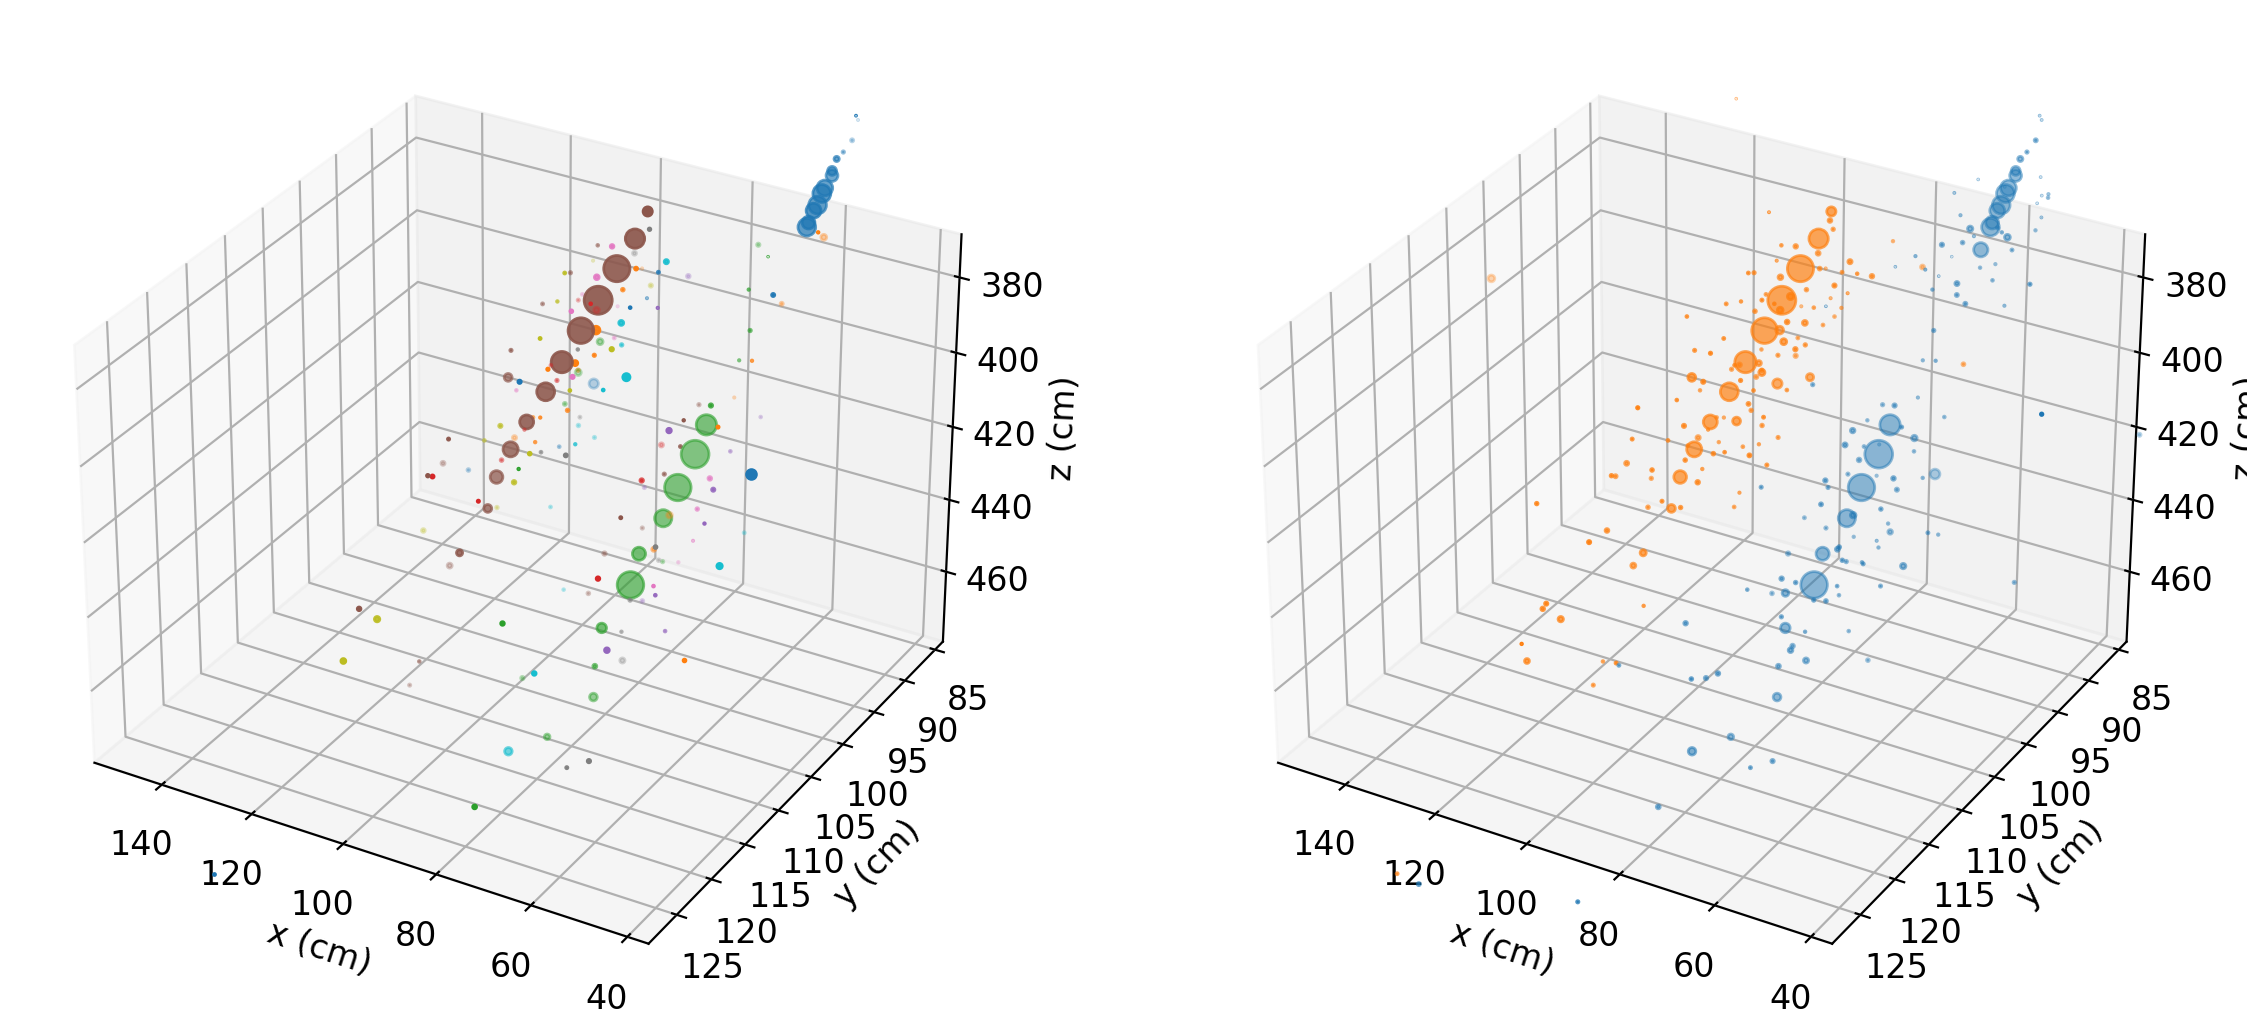

In [27]:
fig = plt.figure(figsize=(14, 7))
ax1, ax2 = plot_sim_reco(
    v_x,
    v_y,
    v_z,
    v_energy,
    sv_x,
    sv_y,
    sv_z,
    sv_energy, 
    sv_indexes,
    sv_multi,
    fig=fig,
    energy_threshold=0,
    zoom=1.25
)
plt.show()
# fig.savefig('export/two-pions-sample.png', dpi=300, bbox_inches='tight', pad_inches=0.2, transparent=True)